# Classically-Boosted Variational Quantum Eigensolver

In [11]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
from matplotlib import pyplot as plt
from scipy import linalg

In [12]:
num_repeats = 100

In [13]:
# Define the molecular Hamiltonian
symbols = ["H", "H"]
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
basis_set = "sto-3g"
electrons = 2
orbitals = 2
Hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    mult=1,
    basis=basis_set,
    active_electrons=electrons,
    active_orbitals=orbitals
)

# Set the number of iterations of the VQE and stepsize
stepsize = 0.4
max_iterations = 30

# Define the HF initial state and fermionic Hamiltonian
hf_state = qml.qchem.hf_state(electrons, qubits)
fermionic_Hamiltonian = qml.utils.sparse_hamiltonian(Hamiltonian).toarray()

# Define all possible single and double excitations
singles, doubles = qml.qchem.excitations(electrons=electrons, orbitals=qubits)
num_theta = len(singles) + len(doubles)

Step = 0,  Energy = -1.12799983 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 12,  Energy = -1.13618883 Ha
Step = 14,  Energy = -1.13618910 Ha
Step = 16,  Energy = -1.13618915 Ha
Step = 18,  Energy = -1.13618916 Ha
Step = 20,  Energy = -1.13618916 Ha
Step = 22,  Energy = -1.13618916 Ha
Step = 24,  Energy = -1.13618916 Ha
Step = 26,  Energy = -1.13618916 Ha
Step = 28,  Energy = -1.13618916 Ha

Final value of the ground-state energy = -1.13618916 Ha

Optimal values of the circuit parameter =,  [0.         0.         0.20973221]


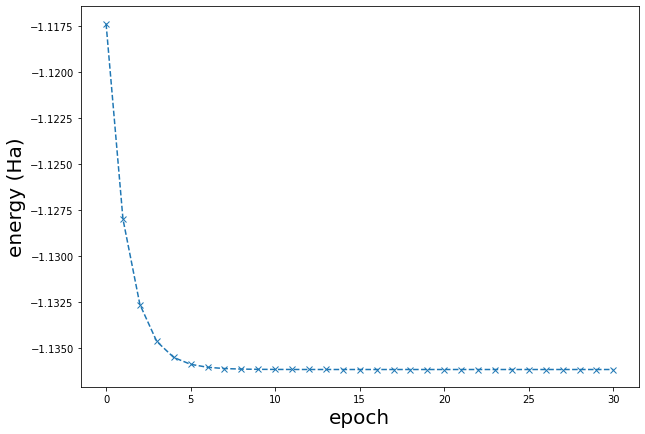

In [14]:
# Define the cost function and the circuit
def circuit_VQE(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf_state,
        singles = singles,
        doubles = doubles)

# Define a device
dev = qml.device('default.qubit', wires=qubits)

@qml.qnode(dev)
def cost_fn(theta):
    circuit_VQE(theta,range(qubits)) # Why define outside?
    return qml.expval(Hamiltonian)

# Draw circuit
# qml.drawer.use_style('black_white')
# qml.draw_mpl(cost_fn, expansion_strategy="device")(np.zeros(num_theta))

# Gradient descent optimization
opt = qml.GradientDescentOptimizer(stepsize=stepsize)
theta = np.zeros(num_theta, requires_grad=True)

#  Initial energy
energy = [cost_fn(theta)]
angle = [theta]

for n in range(max_iterations):

    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal values of the circuit parameter =, ", angle[-1])

# Plot epochs
plt.figure(figsize=(10,7))
plt.plot(energy ,"x--")
plt.xlabel("epoch", fontsize=20)
plt.ylabel("energy (Ha)", fontsize=20)

# Append energies and optimized thetas
energy = energy[-1]
opt_theta = angle[-1]

In [15]:
# Obtain HF energy
binary_string = ''.join([str(i) for i in hf_state])
idx0 = int(binary_string, 2)
H11 = fermionic_Hamiltonian[idx0][idx0]

# Circuit that maps a product state
def circuit_product_state(state):
    qml.BasisState(state, range(qubits))
 
# Number of shots
num_shots_list = np.arange(10, 100, 5)

# Initialize params
energies_VQE = np.zeros(shape=(num_repeats, len(num_shots_list)))
angles_VQE = np.zeros(shape=(num_repeats, len(num_shots_list), num_theta))
energies_CBVQE = np.zeros(shape=(num_repeats, len(num_shots_list)))

# Define the cost function and the circuit
def circuit_VQE(theta, wires):
    qml.AllSinglesDoubles(
        weights = theta,
        wires = wires,
        hf_state = hf_state,
        singles = singles,
        doubles = doubles)

for rep_idx in range(num_repeats):
    
    for ns ,num_shots in enumerate(num_shots_list):
        
        dev_shots1 = qml.device("default.qubit", wires=range(qubits), shots=int(num_shots))
        @qml.qnode(dev_shots1)
        def cost_fn(theta):
            circuit_VQE(theta,range(qubits)) # Why define outside?
            return qml.expval(Hamiltonian)

        # Obtain VQE energy
        H22 = -10
        while H22 < energy:
            H22 = cost_fn(opt_theta)
 
        # Get crossed terms
        wires = range(qubits + 1)
        dev = qml.device("default.qubit", wires=wires)
        Vq = qml.matrix(circuit_VQE)(opt_theta, range(qubits))

        @qml.qnode(dev)
        def hadamard_test(Vq, Vcl, component='real'):

            if component == 'imag':
                qml.RX(np.pi/2, wires=[0])

            qml.Hadamard(wires=[0])
            qml.ControlledQubitUnitary(Vq.conjugate().T @ Vcl, control_wires=[0], wires=wires[1:])
            qml.Hadamard(wires=[0])

            return qml.probs(wires=[0])

        # Compute crossed terms
        H12 = 0
        basis_states = np.array([[1,1,0,0], [0,1,1,0], [1,0,0,1], [0,0,1,1]], requires_grad=True)
        for i, basis_state in enumerate(basis_states):
            Vcl = qml.matrix(circuit_product_state)(basis_state)
            probs = hadamard_test(Vq, Vcl)
            y = 2*probs[0]-1
            binary_string = ''.join([str(i) for i in basis_state])
            idx = int(binary_string, 2)
            overlap_H = fermionic_Hamiltonian[idx0][idx]
            H12 += y*overlap_H
            if i == 0:
                y0 = y

        H21 = np.conjugate(H12)

        S = np.array([[1, y0],[y0, 1]])
        H = np.array([[H11, H12],[H21, H22]])

        evals = linalg.eigvals(np.real(H), np.real(S))
        
        CBGS = np.min(evals).real
        
        energies_VQE[rep_idx, ns] = H22
        energies_CBVQE[rep_idx, ns] = CBGS
        
        #print(H22, CBGS)

In [17]:
# Print actual GS energy (diagonalize fermionic Hamiltonian)
from scipy.sparse.linalg import eigs
E0 = eigs(fermionic_Hamiltonian)[0][0]
print(np.real(E0))

-1.136189162464439


In [18]:
np.savetxt("num_shots_list.csv", num_shots_list, delimiter=", ")
np.savetxt("energies_VQE.csv", energies_VQE, delimiter=", ")
np.savetxt("energies_CBVQE.csv", energies_CBVQE, delimiter=", ")

In [19]:
E0 = -1.1361891624641414
num_shots_list = np.genfromtxt("num_shots_list.csv", delimiter=", ")
energies_VQE = np.genfromtxt("energies_VQE.csv", delimiter=", ")
energies_CBVQE = np.genfromtxt("energies_CBVQE.csv",delimiter=", ")

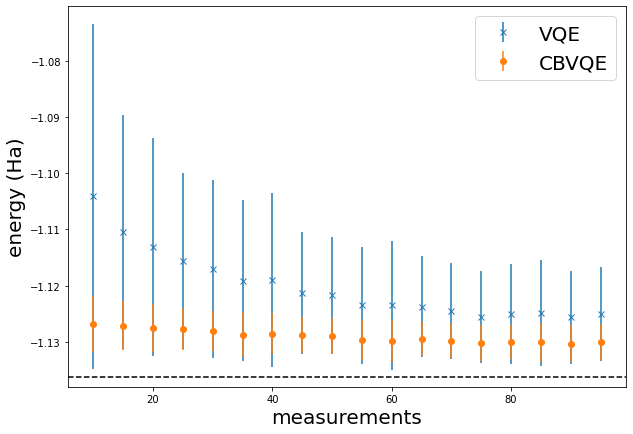

In [21]:
# Plot results
plt.figure(figsize=(10,7))

avg_energies_CBVQE = np.mean(energies_CBVQE, axis=0)
std_eneriges_CBVQE = np.std(energies_CBVQE, axis=0)

avg_energies_VQE = np.mean(energies_VQE, axis=0)
std_eneriges_VQE = np.std(energies_VQE, axis=0)

plt.errorbar(num_shots_list, avg_energies_VQE, yerr=std_eneriges_VQE, fmt='x', label='VQE')
plt.errorbar(num_shots_list, avg_energies_CBVQE, yerr=std_eneriges_CBVQE, fmt='o', label='CBVQE')
plt.axhline(np.real(E0), color='k', linestyle='--')
plt.legend(fontsize=20)
plt.xlabel("measurements", fontsize=20)
plt.ylabel("energy (Ha)", fontsize=20)
plt.savefig('energy_deviation.png')